   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2022, MBARI</div>

  * Distributed under the terms of the GPL License
  * Maintainer: John Ryan ryjo@mbari.org
  * Authors: John Ryan ryjo@mbari.org, Carlos Rueda carueda@mbari.org, Danelle Cline dcline@mbari.org

## Listening to *Pacific Ocean Sound* recordings

Ocean sound recordings have tremendous potential for use by sound artists, naturalists, and educators whose primary goal is to listen rather than analyze.  This notebook illustrates how to extract a period of recording from the *Pacific Ocean Sound* archive and process it for listening.  After processing, you can listen right in this notebook, and you can download the processed file for use elsewhere.

## Selecting a time to listen

Approaching 7 years of continuous recording, this growing audio archive offers an unfathomable depth of potential listening.  How can you survey this sea of sound for a period that may be of interest for listening?

One resource is knowledge of the behavioral ecology of species that you want to hear.  For example, the songs of baleen whales (especially humpback, blue and fin whales) can be heard largely during fall where we are recording (off central California).  So, listening during any time between about August and November, you are likely to encounter their songs.

A more focused way to search is to use our [visual browsing interface](https://www.mbari.org/at-sea/cabled-observatory/mars-science-experiments/mars-hydrophone-data/) (see *Browsing the spectrograms*).  Here, the soundscape comes to life visually, and the visual signatures of different species can be viewed hour by hour for any period of recording since the start of recording in July 2015.  Once you become familiar with how the sounds of different species appear visually in a spectrogram, you can easily select a time when an interesting sound pattern is visually evident in the soundscape, and you can use the methods presented here to listen.  The only information you need from the visual browsing interface is the date and time range of interest.

## Example sounds

Below we'll list times when you can extract and listen to the sounds of different species.  The vocalizations of some species are abundant, however hearing them requires a subwoofer speaker or good headphones because the sound has such a low pitch.  So, for these examples we'll focus on vocalizations of species that can be easily heard through ordinary computer speakers: *humpback whales, orcas, and dolphins*.

The original recordings have a sample rate of 256 kHz, while the upper limit of human hearing is about 20 kHz.  So the original recordings are a bit much for just listening.  For demonstration purposes here, we'll tap into a version of the  audio data that covers part of our hearing range: 16 kHz data (representing sounds up to 8 kHz).  A companion notebook will illustrate how to listen to higher frequency sounds, including slowing down playback of sounds that are above the range of human hearing so that they can be heard.

## Install required dependencies

First, let's install the required software dependencies. 

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed. 

In [1]:
!apt-get update -y && apt-get install -y libsndfile1
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
!pip install sox --quiet
!pip install panel --quiet
!pip install soundfile --quiet
!pip install holoviews --quiet

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree      

### Import all packages

In [2]:
import matplotlib.pyplot as plt
import numpy
import sox
from six.moves.urllib.request import urlopen
import io
import soundfile as sf
# Add widget for playback and spectrogram with playhead:
from scipy.signal import spectrogram
import panel as pn
pn.extension()
import holoviews as hv
hv.extension("bokeh", logo=False)

# Extract a recording from the archive

Now, let's pull examples from the data archive.  The code below allows you to specify one of a few species (change the name inside the quotes for the line at the top beginning with *animal =* .  For each example the start time and duration of a recording segment are already defined.

***This step will require about 150 seconds to complete.*** (The slowness is due to reading an entire daily file before subsetting; this may be sped up in future versions.)

In [3]:
# For testing this processing, you can specify from a number of examples:
# humpback whale, orcas, dolphins
animal = "orcas"  # modify the selection inside the quotes

if animal == "humpback whale":
  # year, month, day, starthour, startminute, startsecond = 2017, 11, 7, 23, 24, 23
  year, month, day, starthour, startminute, startsecond = 2015, 12, 7, 6, 58, 15
elif animal == "orcas":
  year, month, day, starthour, startminute, startsecond = 2018, 4, 13, 8, 42, 35
elif animal == "dolphins":
  year, month, day, starthour, startminute, startsecond = 2015, 7, 31, 23, 12, 11

readseconds = 55  # for all examples; you can modify for longer segments

print(f'Extracting recording of {animal}: {readseconds} seconds starting {year}/{month:0>2}/{day:0>2} {starthour:0>2}:{startminute:0>2}:{startsecond:0>2}')
filename = f'MARS-{year}{month:0>2}{day:0>2}T000000Z-16kHz.wav'
url = f'http://pacific-sound-16khz.s3.amazonaws.com/{year}/{month:0>2}/{filename}'
print(f'Loading audio data from {url}')

# Might load data from archives having different sample rates, so read that first.
_, sample_rate = sf.read(io.BytesIO(urlopen(url).read(1000)), dtype='float32')
print(f'File audio sample rate   = {sample_rate} Hz')

startsampl = starthour*60*60*sample_rate + startminute*60*sample_rate + startsecond*sample_rate;
endsampl = startsampl + readseconds*sample_rate

psound_segment, _ = sf.read(io.BytesIO(urlopen(url).read()), start=startsampl, stop=endsampl, dtype='float32')
nsec = psound_segment.size/sample_rate
print(f'Loaded {nsec} seconds')



Extracting recording of orcas: 55 seconds starting 2018/04/13 08:42:35
Loading audio data from http://pacific-sound-16khz.s3.amazonaws.com/2018/04/MARS-20180413T000000Z-16kHz.wav
File audio sample rate   = 16000 Hz
Loaded 55.0 seconds


# Plot the raw audio data

Let's see why we need to modify the raw audio data for listening.

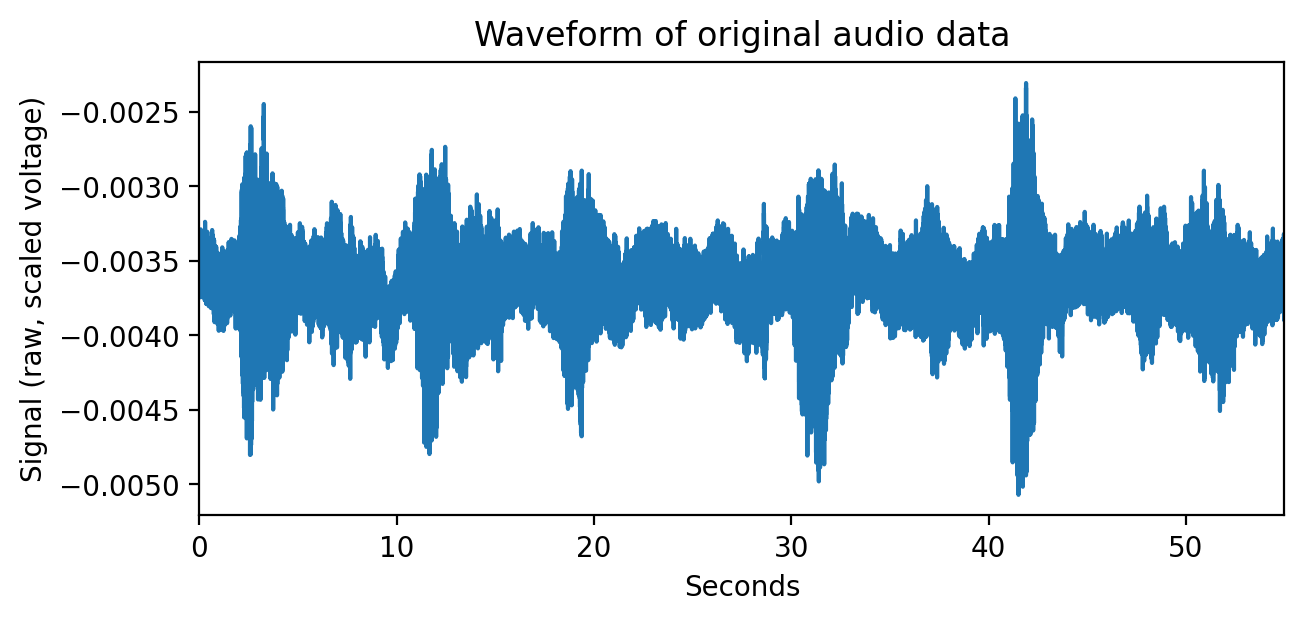

In [4]:
# create a time reference for the raw audio segment
segment_seconds = numpy.linspace(0,nsec,len(psound_segment))

plt.figure(dpi=200, figsize = [7,3])
plt.plot(segment_seconds,psound_segment)
plt.xlabel('Seconds')
plt.ylabel('Signal (raw, scaled voltage)')
plt.title('Waveform of original audio data')
plt.autoscale(enable=True, axis='x', tight=True)

# Modify for listening
Attributes of the raw audio (above) that we need to change for listening are:
* remove the DC offset (center on zero)
* increase the signal amplitude

For this, we'll use Sound eXchange (SoX).

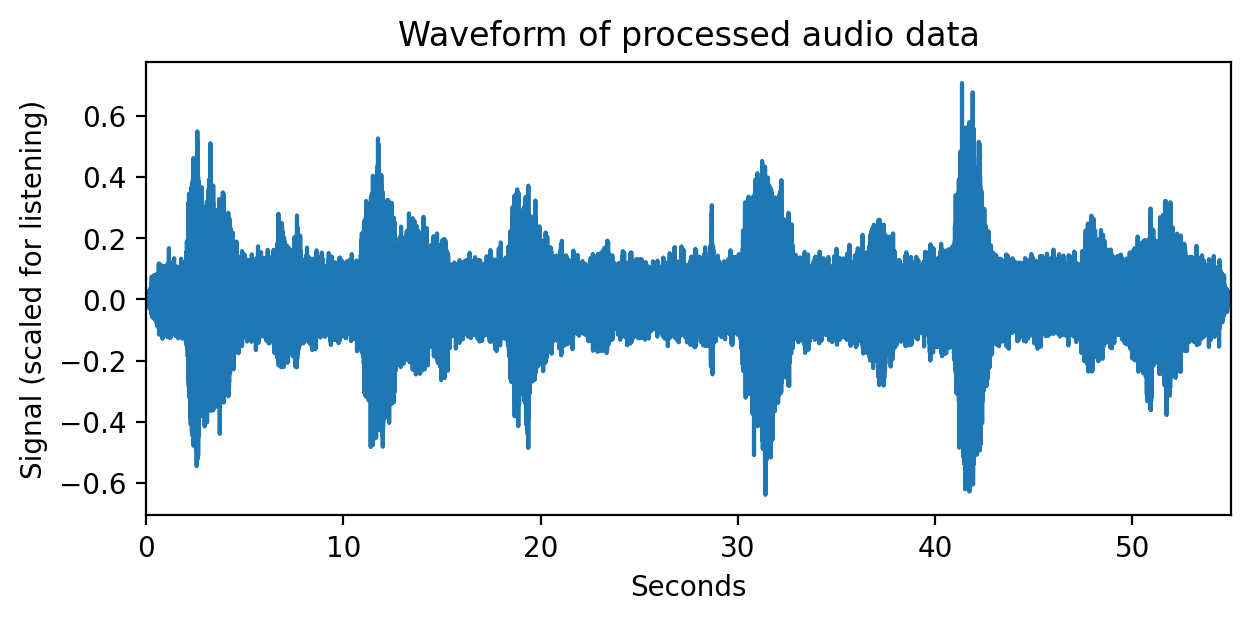

In [5]:
# create a SoX transformer with:
# * a highpass filter to remove the DC offset
# * fade in/out for easy listening
# * normalization to increase the amplitude
tfm = sox.Transformer()
tfm.highpass(10)
tfm.fade(fade_in_len=1, fade_out_len=1)
tfm.norm(db_level = -3.0)
processed_audio = tfm.build_array(input_array=psound_segment, sample_rate_in=sample_rate)

# View the processed audio segment
plt.figure(dpi=200, figsize = [7,3])
plt.plot(segment_seconds,processed_audio)
plt.xlabel('Seconds')
plt.ylabel('Signal (scaled for listening)')
plt.title('Waveform of processed audio data')
plt.autoscale(enable=True, axis='x', tight=True)

# Save the result as a wav file
OUTPUT_FILENAME = 'audio_data.wav'
sf.write(OUTPUT_FILENAME, processed_audio, sample_rate)

***The processed audio data plotted above has been saved to the file audio_data.wav.***

# Listen
In this section, you can listen to your processed audio data in two ways.  Try both.

## 1. Sound only
After you run the code, the player will appear.

In [6]:
# Playback:
import IPython
IPython.display.Audio(OUTPUT_FILENAME)

## Sound and its visual representation (spectrogram)
After you run the code, the player will appear.

In [7]:
x = segment_seconds

f, t, sxx = spectrogram(processed_audio, sample_rate, window='hann')

spec_gram = hv.Image((t, f, numpy.log10(sxx)), 
                     ["Time (s)", "Frequency (Hz)"]
                     ).opts(width=1000)

spec_gram_c = spec_gram.opts(cmap='gray_r')

audio = pn.pane.Audio(OUTPUT_FILENAME, sample_rate=sample_rate, name='Audio', throttle=50)

def update_playhead(x,y,t):
    if x is None:
        return hv.VLine(t + 0.5)
    else:
        audio.time = x
        return hv.VLine(x + 0.5)

tap_stream = hv.streams.SingleTap(transient=True)
time_play_stream = hv.streams.Params(parameters=[audio.param.time], rename={'time': 't'})
dmap_time = hv.DynamicMap(update_playhead, streams=[time_play_stream, tap_stream])

pn.Column(spec_gram_c * dmap_time, audio)

Column
    [0] HoloViews(DynamicMap)
    [1] Audio(str, sample_rate=16000, throttle=50)

# Notes
* The 16 kHz data are great for listening, but they do not fully cover the range of human hearing.  When you view the spectrogram of the example dolphin recording, you may notice that the sound energy extends up to the limit of this decimated recording (8 kHz).  Sounds from the dolphins certainly extend above this, and a companion notebook will illustrate how to extract audio spanning the full range of human hearing.
* A convenient way to transition between the example sounds is to (1) [clear all outputs], and (2) [restart and run all].